# EDA of Average Team Statistics

## Overview

This EDA will look into the following statistics:  
  
* The average two point shooting percentage of teams per season.
* The average three point shooting percentage of teams per season.
* The average free throw shooting percentage of teams per season.
* The average offensive rebounds of teams per season.
* The average defensive rebounds of teams per season.

### Discussion of the data
  
Kaggle provided statistics about every NCAA division 1 game played between the 2003 and 2018 seasons, inclusive, in the RegSeasonDetailedResults csv file.  

RegSeasonDetailedResults has the following fields.  The 'W' means the winning team, and there is a similar set for the losing team that starts with 'L':

| Field | Meaning |
|:-----------|:------------|
|WFGM|field goals made|
|WFGA|field goals attempted|
|WFGM3|three pointers made|
|WFGA3|three pointers attempted|
|WFTM|free throws made|
|WFTA|free throws attempted|
|WOR|offensive rebounds|
|WDR|defensive rebounds|
|WAst|assists|
|WTO|turnovers committed|
|WStl|steals|
|WBlk|blocks|
|WPF|personal fouls committed|

The RegSeasonDetailedResults data set did not have two point shooting statistics, so this information had to be calculated by subtracting the total number of three point shots from the total number of field goals.

Using this data set, it is possible to get average statistics for each team by first splitting the winning and losing team stats into a combined table, and then grouping the data by season and team.

An update query was used to calculate yearly average statistics in a temp table, and this information was populated in the 'features' table by joining it with the temp table.

## Data Preparation

In [70]:
import psycopg2 as pg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind, ttest_ind_from_stats
from sqlalchemy import create_engine

In [71]:
# Establish connection to postgres
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

In [72]:
# Select all the rows from the 'features' table except the 2018 tournament
query1 = ''' SELECT * FROM prod."features" WHERE "Season Type" = 'Regular' '''
query2 = ''' SELECT * FROM prod."features_tournament" WHERE "Season" != 2018 '''
df_stats = pd.read_sql_query(query1, conn)
df_stats_tournament = pd.read_sql_query(query2, conn)
conn.close()

In [73]:
# Remove rows with NaN:
df_stats = df_stats.dropna(subset=['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent'])
df_stats_tournament = df_stats_tournament.dropna(subset=['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent'])

In [74]:
# Look at the columns of the data frame
df_stats.columns

Index([u'Season', u'DayNum', u'Team', u'Opponent', u'Outcome', u'Score',
       u'OpponentScore', u'NumOT', u'WLoc', u'Season Type', u'holdout_s1',
       u'holdout_s2', u'AvgRank', u'OpponentAvgRank', u'TwoPointPct_Team',
       u'ThreePointPct_Team', u'FreeThrowPct_Team', u'OffensiveRebounds_Team',
       u'DefensiveRebounds_Team', u'TwoPointPct_Opponent',
       u'ThreePointPct_Opponent', u'FreeThrowPct_Opponent',
       u'OffensiveRebounds_Opponent', u'DefensiveRebounds_Opponent', u'WinPct',
       u'OpponentWinPct', u'WinPctDiff', u'AvgPointsFor', u'AvgPointsAgainst',
       u'AvgNetPointsFor', u'SeedDiff', u'OpponentAvgPointsFor',
       u'OpponentAvgPointsAgainst', u'OpponentAvgNetPointsFor'],
      dtype='object')

Calculate Statistics for Winning Teams v. Losing Teams

Create a winlose dataframe

In [75]:
df_winlose = pd.DataFrame(data={'Season Type':df_stats['Season Type'],
                                'Outcome':df_stats['Outcome'],
                                'TwoPointPctWin':np.zeros(len(df_stats)),
                                'TwoPointPctLose':np.zeros(len(df_stats)),
                                'ThreePointPctWin':np.zeros(len(df_stats)),
                                'ThreePointPctLose':np.zeros(len(df_stats)),
                                'FreeThrowPctWin':np.zeros(len(df_stats)),
                                'FreeThrowPctLose':np.zeros(len(df_stats)),
                                'OffensiveReboundsWin':np.zeros(len(df_stats)),
                                'OffensiveReboundsLose':np.zeros(len(df_stats)),
                                'DefensiveReboundsWin':np.zeros(len(df_stats)),
                                'DefensiveReboundsLose':np.zeros(len(df_stats))})

df_winlose_tournament = pd.DataFrame(data={'Season Type':df_stats_tournament['Season Type'],
                                'Outcome':df_stats_tournament['Outcome'],
                                'TwoPointPctWin':np.zeros(len(df_stats_tournament)),
                                'TwoPointPctLose':np.zeros(len(df_stats_tournament)),
                                'ThreePointPctWin':np.zeros(len(df_stats_tournament)),
                                'ThreePointPctLose':np.zeros(len(df_stats_tournament)),
                                'FreeThrowPctWin':np.zeros(len(df_stats_tournament)),
                                'FreeThrowPctLose':np.zeros(len(df_stats_tournament)),
                                'OffensiveReboundsWin':np.zeros(len(df_stats_tournament)),
                                'OffensiveReboundsLose':np.zeros(len(df_stats_tournament)),
                                'DefensiveReboundsWin':np.zeros(len(df_stats_tournament)),
                                'DefensiveReboundsLose':np.zeros(len(df_stats_tournament))})

Create a data set for determining the statistics for the winning teams and losing teams.

In [76]:
df_winlose.loc[df_stats['Outcome'] == 1, 'TwoPointPctWin'] = df_stats[df_stats['Outcome'] == 1]['TwoPointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'TwoPointPctWin'] = df_stats[df_stats['Outcome'] == 0]['TwoPointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'TwoPointPctLose'] = df_stats[df_stats['Outcome'] == 1]['TwoPointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'TwoPointPctLose'] = df_stats[df_stats['Outcome'] == 0]['TwoPointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'ThreePointPctWin'] = df_stats[df_stats['Outcome'] == 1]['ThreePointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'ThreePointPctWin'] = df_stats[df_stats['Outcome'] == 0]['ThreePointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'ThreePointPctLose'] = df_stats[df_stats['Outcome'] == 1]['ThreePointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'ThreePointPctLose'] = df_stats[df_stats['Outcome'] == 0]['ThreePointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'FreeThrowPctWin'] = df_stats[df_stats['Outcome'] == 1]['FreeThrowPct_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'FreeThrowPctWin'] = df_stats[df_stats['Outcome'] == 0]['FreeThrowPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'FreeThrowPctLose'] = df_stats[df_stats['Outcome'] == 1]['FreeThrowPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'FreeThrowPctLose'] = df_stats[df_stats['Outcome'] == 0]['FreeThrowPct_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'OffensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 1]['OffensiveRebounds_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'OffensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 0]['OffensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'OffensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 1]['OffensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'OffensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 0]['OffensiveRebounds_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'DefensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 1]['DefensiveRebounds_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'DefensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 0]['DefensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'DefensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 1]['DefensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'DefensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 0]['DefensiveRebounds_Team']

In [77]:
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'TwoPointPctWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['TwoPointPct_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'TwoPointPctWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['TwoPointPct_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'TwoPointPctLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['TwoPointPct_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'TwoPointPctLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['TwoPointPct_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'ThreePointPctWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['ThreePointPct_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'ThreePointPctWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['ThreePointPct_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'ThreePointPctLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['ThreePointPct_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'ThreePointPctLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['ThreePointPct_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'FreeThrowPctWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['FreeThrowPct_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'FreeThrowPctWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['FreeThrowPct_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'FreeThrowPctLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['FreeThrowPct_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'FreeThrowPctLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['FreeThrowPct_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'OffensiveReboundsWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['OffensiveRebounds_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'OffensiveReboundsWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['OffensiveRebounds_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'OffensiveReboundsLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['OffensiveRebounds_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'OffensiveReboundsLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['OffensiveRebounds_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'DefensiveReboundsWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['DefensiveRebounds_Team']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'DefensiveReboundsWin'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['DefensiveRebounds_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 1, 'DefensiveReboundsLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 1]['DefensiveRebounds_Opponent']
df_winlose_tournament.loc[df_stats_tournament['Outcome'] == 0, 'DefensiveReboundsLose'] = df_stats_tournament[df_stats_tournament['Outcome'] == 0]['DefensiveRebounds_Team']

Get Data Sets for the Regular Season and Tournaments

In [78]:
#df_reg_season = df_stats[df_stats["Season Type"] == "Regular"]
#df_winlose_reg_season = df_winlose[df_winlose["Season Type"] == "Regular"]
df_reg_season = df_stats
df_winlose_reg_season = df_winlose
df_tourney = df_stats_tournament
df_winlose_tourney = df_winlose_tournament

## Average Two Point Shooting Percentage

### Regular Season

Descriptive Statistics for Two Point Shooting Percentages for the Regular Season

In [79]:
df_reg_season[['TwoPointPct_Team']].describe()

,TwoPointPct_Team
count,157378.000000
mean,0.483631
std,0.047523
min,0.136364
25%,0.455243
50%,0.483950
75%,0.512122
max,0.933333


Descriptive Statistics for TwoPointPctWin / TwoPointPctLose for the Regular Season

In [80]:
df_winlose_reg_season[['TwoPointPctWin', 'TwoPointPctLose']].describe()

,TwoPointPctWin,TwoPointPctLose
count,157378.000000,157378.000000
mean,0.492538,0.474725
std,0.046501,0.046859
min,0.136364,0.137931
25%,0.464246,0.447398
50%,0.491865,0.475897
75%,0.519498,0.503299
max,0.875000,0.933333


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

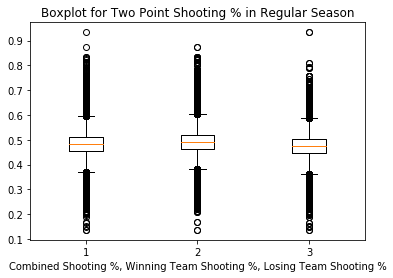

In [81]:
data = [df_reg_season['TwoPointPct_Team'], df_winlose_reg_season['TwoPointPctWin'], df_winlose_reg_season['TwoPointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Two Point Shooting % in Regular Season')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Two Point % of Winning Team v. Losing Team')

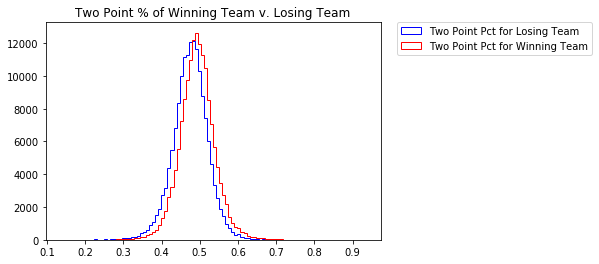

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Two Point Pct for Winning Team', 'Two Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['TwoPointPctWin'], df_winlose_reg_season['TwoPointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Two Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [83]:
t, p = ttest_ind(df_winlose_reg_season['TwoPointPctWin'], df_winlose_reg_season['TwoPointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 107.05  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [84]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['TwoPointDifference'] = df_reg_season['TwoPointPct_Team'] - df_reg_season['TwoPointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.28


### Tournament

Descriptive Statistics for Two Point Shooting Percentages for the Tournament

In [85]:
df_tourney[['TwoPointPct_Team']].describe()

,TwoPointPct_Team
count,930.000000
mean,0.526880
std,0.078962
min,0.236842
25%,0.472222
50%,0.524405
75%,0.579419
max,0.800000


Descriptive Statistics for TwoPointPctWin / TwoPointPctLose for the Tournament

In [86]:
df_winlose_tourney[['TwoPointPctWin', 'TwoPointPctLose']].describe()

,TwoPointPctWin,TwoPointPctLose
count,930.000000,930.000000
mean,0.536062,0.517698
std,0.080106,0.076709
min,0.285714,0.236842
25%,0.482759,0.466667
50%,0.538462,0.513514
75%,0.589744,0.571895
max,0.800000,0.781250


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

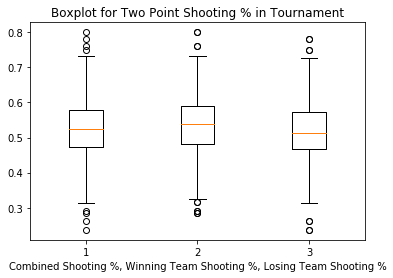

In [87]:
data = [df_tourney['TwoPointPct_Team'], df_winlose_tourney['TwoPointPctWin'], df_winlose_tourney['TwoPointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Two Point Shooting % in Tournament')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Two Point % of Winning Team v. Losing Team')

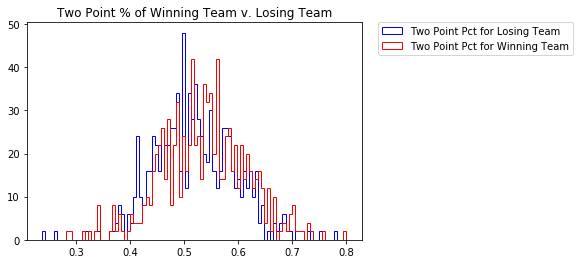

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Two Point Pct for Winning Team', 'Two Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['TwoPointPctWin'], df_winlose_tourney['TwoPointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Two Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [89]:
t, p = ttest_ind(df_winlose_tourney['TwoPointPctWin'], df_winlose_tourney['TwoPointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 5.05  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [90]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['TwoPointDifference'] = df_tourney['TwoPointPct_Team'] - df_tourney['TwoPointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.16


### Analysis

The mean two point shooting percent for the regular season is 48.4% whereas the mean two point shooting percent in the tournament is 52.7%, so the two point shooting percentage is better for tournament teams, which makes sense.  

For the regular season, the difference between the mean two point shooting percentage of winning teams (49.3%) v. losing teams (47.3%) is about 2%, and is statistically significant.  The correlation between the two point shooting of the teams and the outcome of the game (win/lose) is 0.28, which indicates a weak linear relationship.

For the tournament, the difference between the mean two point shooting percentage of winning teams (53.6%) v. losing teams (51.8%) is about 1.8%, which is small, but it is statistically significant.  The correlation between the two point shooting of the teams and the outcome of the game (win/lose) is 0.16, which indicates a very weak linear relationship.

Therefore, the two point shooting percentage may provide some benefit in predicting the outcome of early tournament games, which are more similar to regular season games.

## Average Three Point Shooting Percentage

### Regular Season

Descriptive Statistics for Three Point Shooting Percentages for the Regular Season

In [91]:
df_reg_season[['ThreePointPct_Team']].describe()

,ThreePointPct_Team
count,157378.000000
mean,0.341971
std,0.047310
min,0.000000
25%,0.315633
50%,0.342551
75%,0.369568
max,0.777778


Descriptive Statistics for ThreePointPctWin / ThreePointPctLose for the Regular Season

In [92]:
df_winlose_reg_season[['ThreePointPctWin', 'ThreePointPctLose']].describe()

,ThreePointPctWin,ThreePointPctLose
count,157378.000000,157378.000000
mean,0.346723,0.337219
std,0.046782,0.047357
min,0.000000,0.000000
25%,0.320499,0.310811
50%,0.347062,0.337886
75%,0.373942,0.364864
max,0.777778,0.750000


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

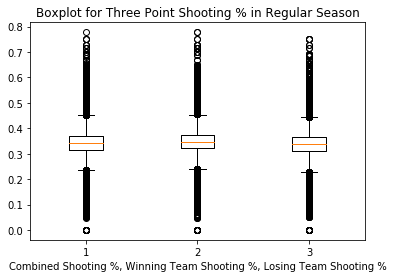

In [93]:
data = [df_reg_season['ThreePointPct_Team'], df_winlose_reg_season['ThreePointPctWin'], df_winlose_reg_season['ThreePointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Three Point Shooting % in Regular Season')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Three Point % of Winning Team v. Losing Team')

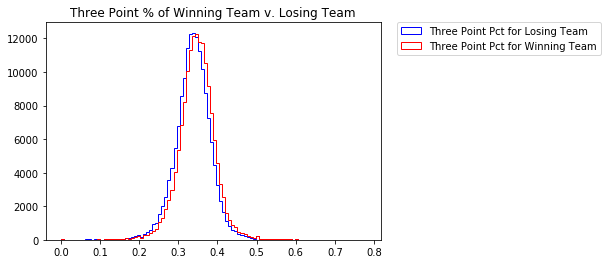

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Three Point Pct for Winning Team', 'Three Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['ThreePointPctWin'], df_winlose_reg_season['ThreePointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Three Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [95]:
t, p = ttest_ind(df_winlose_reg_season['ThreePointPctWin'], df_winlose_reg_season['ThreePointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 56.64  p = 0.0000


#### Correlation Between (ThreePointPct_Team - ThreePointPct_Opponent) and Outcome

In [96]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['ThreePointDifference'] = df_reg_season['ThreePointPct_Team'] - df_reg_season['ThreePointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.15


### Tournament

Descriptive Statistics for Three Point Shooting Percentages for the Tournament

In [97]:
df_tourney[['ThreePointPct_Team']].describe()

,ThreePointPct_Team
count,930.000000
mean,0.384831
std,0.094416
min,0.000000
25%,0.331293
50%,0.384512
75%,0.442951
max,0.750000


Descriptive Statistics for ThreePointPctWin / ThreePointPctLose for the Tournament

In [98]:
df_winlose_tourney[['ThreePointPctWin', 'ThreePointPctLose']].describe()

,ThreePointPctWin,ThreePointPctLose
count,930.000000,930.000000
mean,0.383554,0.386108
std,0.095633,0.093165
min,0.000000,0.000000
25%,0.326028,0.333333
50%,0.380273,0.384615
75%,0.440000,0.444444
max,0.733333,0.750000


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

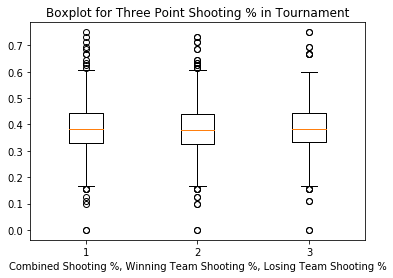

In [99]:
data = [df_tourney['ThreePointPct_Team'], df_winlose_tourney['ThreePointPctWin'], df_winlose_tourney['ThreePointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Three Point Shooting % in Tournament')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Three Point % of Winning Team v. Losing Team')

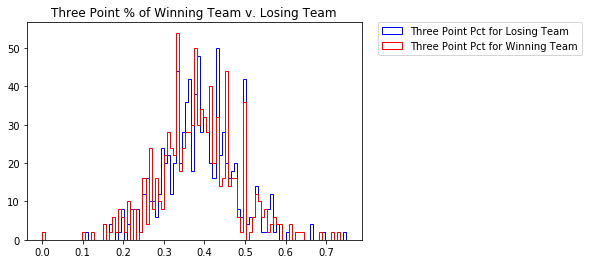

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Three Point Pct for Winning Team', 'Three Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['ThreePointPctWin'], df_winlose_tourney['ThreePointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Three Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [101]:
t, p = ttest_ind(df_winlose_tourney['ThreePointPctWin'], df_winlose_tourney['ThreePointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = -0.58  p = 0.5598


#### Correlation Between (ThreePointPct_Team - ThreePointPct_Opponent)  and Outcome

In [102]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['ThreePointDifference'] = df_tourney['ThreePointPct_Team'] - df_tourney['ThreePointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: -0.02


### Analysis

The mean three point shooting in the regular season is 34.2% and it is 38.5% during the tournament.

During the regular season, there is less than a 1% difference between the three point shooting of winning and losing teams, and the difference is statistically significant.  The correlation between the difference in team's three point shooting and the outcome of the game has a correlation of 0.15, which is weakly correlated.

During the tournament, there is a 0.2% difference between the three point shooting of winning and losing teams, and the difference is NOT statistically significant.  The correlation between the difference in team's three point shooting and the outcome of the game has a correlation of -0.02, which is non-correlated.

Because of the lack of correlation between three point shooting and the outcome of games, this feature should not be considered in the model.

## Average Free Throw Shooting Percentage

### Regular Season

Descriptive Statistics for Free Throw Percentages for the Regular Season

In [103]:
df_reg_season[['FreeThrowPct_Team']].describe()

,FreeThrowPct_Team
count,157378.000000
mean,0.684418
std,0.055439
min,0.000000
25%,0.652629
50%,0.686922
75%,0.719430
max,1.000000


Descriptive Statistics for FreeThrowPctWin / FreeThrowPctLose for the Regular Season

In [104]:
df_winlose_reg_season[['FreeThrowPctWin', 'FreeThrowPctLose']].describe()

,FreeThrowPctWin,FreeThrowPctLose
count,157378.000000,157378.000000
mean,0.688277,0.680559
std,0.053704,0.056860
min,0.125000,0.000000
25%,0.656706,0.648658
50%,0.690468,0.683280
75%,0.722367,0.716212
max,1.000000,1.000000


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

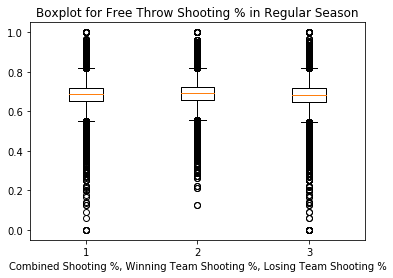

In [105]:
data = [df_reg_season['FreeThrowPct_Team'], df_winlose_reg_season['FreeThrowPctWin'], df_winlose_reg_season['FreeThrowPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Free Throw Shooting % in Regular Season')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Free Throw % of Winning Team v. Losing Team')

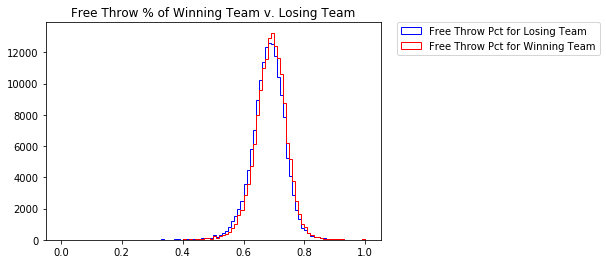

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Free Throw Pct for Winning Team', 'Free Throw Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['FreeThrowPctWin'], df_winlose_reg_season['FreeThrowPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Free Throw % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [107]:
t, p = ttest_ind(df_winlose_reg_season['FreeThrowPctWin'], df_winlose_reg_season['FreeThrowPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 39.14  p = 0.0000


#### Correlation Between (FreeThrowPct_Team - FreeThrowPct_Opponent) and Outcome

In [108]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['FreeThrowDifference'] = df_reg_season['FreeThrowPct_Team'] - df_reg_season['FreeThrowPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.10


### Tournament

Descriptive Statistics for Free Throw Percentages for the Tournament

In [109]:
df_tourney[['FreeThrowPct_Team']].describe()

,FreeThrowPct_Team
count,930.000000
mean,0.724569
std,0.096977
min,0.000000
25%,0.666667
50%,0.730095
75%,0.787530
max,1.000000


Descriptive Statistics for FreeThrowPctWin / FreeThrowPctLose for the Tournament

In [110]:
df_winlose_tourney[['FreeThrowPctWin', 'FreeThrowPctLose']].describe()

,FreeThrowPctWin,FreeThrowPctLose
count,930.000000,930.000000
mean,0.721609,0.727528
std,0.094118,0.099666
min,0.416667,0.000000
25%,0.666667,0.666667
50%,0.724339,0.733333
75%,0.784286,0.788889
max,1.000000,1.000000


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

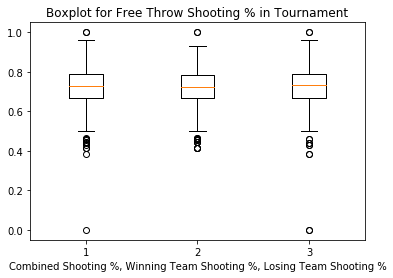

In [111]:
data = [df_tourney['FreeThrowPct_Team'], df_winlose_tourney['FreeThrowPctWin'], df_winlose_tourney['FreeThrowPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Free Throw Shooting % in Tournament')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Free Throw % of Winning Team v. Losing Team')

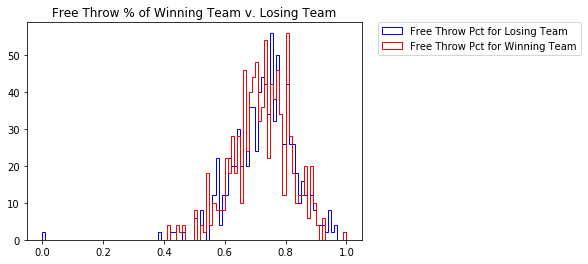

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Free Throw Pct for Winning Team', 'Free Throw Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['FreeThrowPctWin'], df_winlose_tourney['FreeThrowPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Free Throw % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [113]:
t, p = ttest_ind(df_winlose_tourney['FreeThrowPctWin'], df_winlose_tourney['FreeThrowPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = -1.32  p = 0.1881


#### Correlation Between (FreeThrowPct_Team - FreeThrowPct_Opponent) and Outcome

In [114]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['TwoPointDifference'] = df_tourney['FreeThrowPct_Team'] - df_tourney['FreeThrowPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: -0.04


### Analysis

The mean free throw shooting percent for the regular season is 68.4% whereas the mean two point shooting percent in the tournament is 72.5%, so the free throw shooting percentage is better for tournament teams, which makes sense.  

For the regular season, the difference between the mean free throw shooting percentage of winning teams (68.8%) v. losing teams (68.1%) is about 0.7%, and is statistically significant.  The correlation between the free throw shooting of the teams and the outcome of the game (win/lose) is 0.10, which indicates a very weak linear relationship.

For the tournament, the difference between the mean free throw shooting percentage of winning teams (72.2%) v. losing teams (72.8%) is about 0.6%, which is small and it is statistically insignificant (p=0.1881).  The correlation between the free throw shooting of the teams and the outcome of the game (win/lose) is -0.04, which indicates no linear relationship.

Because there is no significant difference between the free throw shooting of winning and losing teams in the tournament, and there is no correlation between free throw shooting and the outcome of a game, this feature should not be considered in the model.

## Average Offensive Rebounds

### Regular Season

Descriptive Statistics for Offensive Rebounds for the Regular Season

In [115]:
df_reg_season[['OffensiveRebounds_Team']].describe()

,OffensiveRebounds_Team
count,157378.000000
mean,11.355906
std,2.228425
min,0.000000
25%,10.000000
50%,11.315789
75%,12.666667
max,32.000000


Descriptive Statistics for OffensiveReboundsWin / OffensiveReboundsLose for the Regular Season

In [116]:
df_winlose_reg_season[['OffensiveReboundsWin', 'OffensiveReboundsLose']].describe()

,OffensiveReboundsWin,OffensiveReboundsLose
count,157378.000000,157378.000000
mean,11.482147,11.229664
std,2.252786,2.196550
min,1.000000,0.000000
25%,10.045455,9.840000
50%,11.428571,11.200000
75%,12.793103,12.555556
max,32.000000,29.000000


#### Boxplots

Text(0.5,0,u'Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

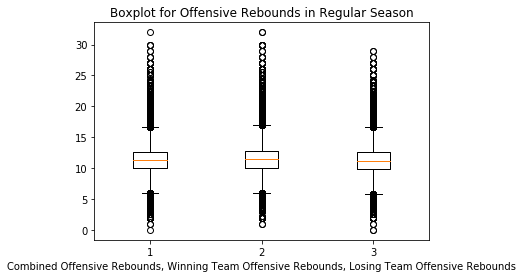

In [117]:
data = [df_reg_season['OffensiveRebounds_Team'], df_winlose_reg_season['OffensiveReboundsWin'], df_winlose_reg_season['OffensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Offensive Rebounds in Regular Season')
plt.xlabel('Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

#### Histogram

Text(0.5,1,u'Offensive Rebounds of Winning Team v. Losing Team')

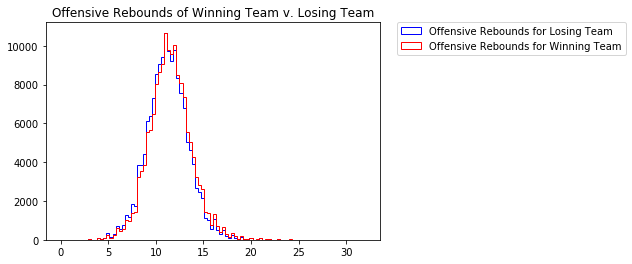

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Offensive Rebounds for Winning Team', 'Offensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['OffensiveReboundsWin'], df_winlose_reg_season['OffensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Offensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [119]:
t, p = ttest_ind(df_winlose_reg_season['OffensiveReboundsWin'], df_winlose_reg_season['OffensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 31.83  p = 0.0000


#### Correlation Between (OffensiveRebounds_Team - OffensiveRebounds_Opponent)  and Outcome

In [120]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['OffensiveReboundsDifference'] = df_reg_season['OffensiveRebounds_Team'] - df_reg_season['OffensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.08


### Tournament

Descriptive Statistics for Offensive Rebounds for the Tournament

In [121]:
df_tourney[['OffensiveRebounds_Team']].describe()

,OffensiveRebounds_Team
count,930.000000
mean,10.772706
std,3.408779
min,0.000000
25%,8.500000
50%,10.500000
75%,13.000000
max,24.000000


Descriptive Statistics for OffensiveReboundsWin / OffensiveReboundsLose for the Tournament

In [122]:
df_winlose_tourney[['OffensiveReboundsWin', 'OffensiveReboundsLose']].describe()

,OffensiveReboundsWin,OffensiveReboundsLose
count,930.000000,930.000000
mean,10.933656,10.611756
std,3.485195,3.322816
min,0.000000,2.000000
25%,9.000000,8.500000
50%,11.000000,10.333333
75%,13.000000,13.000000
max,24.000000,23.000000


#### Boxplots

Text(0.5,0,u'Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

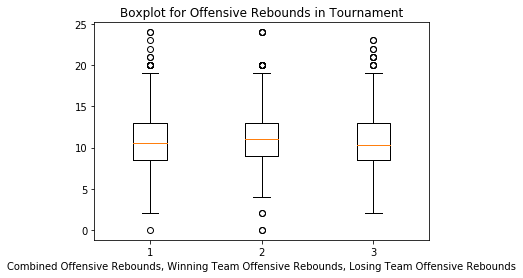

In [123]:
data = [df_tourney['OffensiveRebounds_Team'], df_winlose_tourney['OffensiveReboundsWin'], df_winlose_tourney['OffensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Offensive Rebounds in Tournament')
plt.xlabel('Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

#### Histogram

Text(0.5,1,u'Offensive Rebounds of Winning Team v. Losing Team')

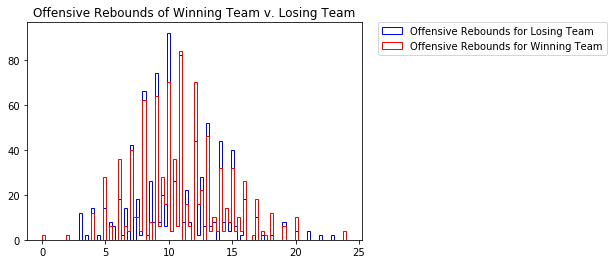

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Offensive Rebounds for Winning Team', 'Offensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['OffensiveReboundsWin'], df_winlose_tourney['OffensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Offensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [125]:
t, p = ttest_ind(df_winlose_tourney['OffensiveReboundsWin'], df_winlose_tourney['OffensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 2.04  p = 0.0416


#### Correlation Between (OffensiveRebounds_Team - OffensiveRebounds_Opponent) and Outcome

In [126]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['OffensiveReboundsDifference'] = df_tourney['OffensiveRebounds_Team'] - df_tourney['OffensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.07


### Analysis

The mean offensive rebounds for the regular season is 11.4 whereas the mean offensive rebounds in the tournament is 10.8, so the offensive rebounding is worse for tournament teams.  

For the regular season, the difference between the mean offensive rebounding of winning teams (11.5) v. losing teams (11.2) is about 0.3, and is statistically significant.  The correlation between the offensive rebounding of the teams and the outcome of the game (win/lose) is 0.08, which indicates no linear relationship.

For the tournament, the difference between the mean offensive rebounding of winning teams (10.9) v. losing teams (10.6) is about 0.3, and is statistically significant at the p=0.05 level.  The correlation between the offensive rebounding of the teams and the outcome of the game (win/lose) is 0.07, which indicates no linear relationship.

Because there is no correlation between offensive rebounding and the outcome of a game, this feature should not be considered in the model.

## Average Defensive Rebounds

### Regular Season

Descriptive Statistics for Defensive Rebounds for the Regular Season

In [127]:
df_reg_season[['DefensiveRebounds_Team']].describe()

,DefensiveRebounds_Team
count,157378.000000
mean,23.790327
std,2.727441
min,6.000000
25%,22.000000
50%,23.680000
75%,25.400000
max,48.000000


Descriptive Statistics for DefensiveReboundsWin/DefensiveReboundsLose for the Regular Season

In [128]:
df_winlose_reg_season[['DefensiveReboundsWin', 'DefensiveReboundsLose']].describe()

,DefensiveReboundsWin,DefensiveReboundsLose
count,157378.000000,157378.000000
mean,24.116981,23.463672
std,2.762765,2.651715
min,8.000000,6.000000
25%,22.350000,21.777778
50%,24.000000,23.368421
75%,25.714286,25.000000
max,48.000000,44.000000


#### Boxplots

Text(0.5,0,u'Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

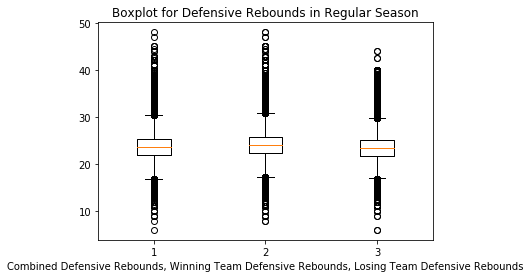

In [129]:
data = [df_reg_season['DefensiveRebounds_Team'], df_winlose_reg_season['DefensiveReboundsWin'], df_winlose_reg_season['DefensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Defensive Rebounds in Regular Season')
plt.xlabel('Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

#### Histogram

Text(0.5,1,u'Defensive Rebounds of Winning Team v. Losing Team')

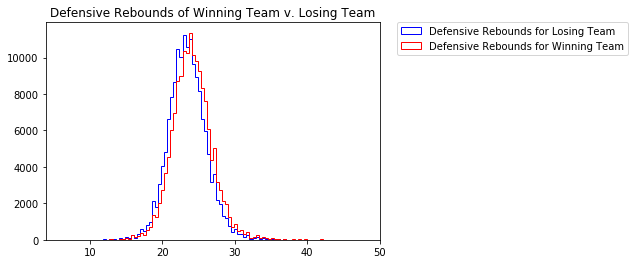

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Defensive Rebounds for Winning Team', 'Defensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['DefensiveReboundsWin'], df_winlose_reg_season['DefensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Defensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [131]:
t, p = ttest_ind(df_winlose_reg_season['DefensiveReboundsWin'], df_winlose_reg_season['DefensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 67.68  p = 0.0000


#### Correlation Between (DefensiveRebounds_Team - DefensiveRebounds_Opponent) and Outcome

In [132]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['DefensiveReboundsDifference'] = df_reg_season['DefensiveRebounds_Team'] - df_reg_season['DefensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.19


### Tournament

Descriptive Statistics for Defensive Rebounds for the Regular Season

In [133]:
df_tourney[['DefensiveRebounds_Team']].describe()

,DefensiveRebounds_Team
count,930.000000
mean,26.004857
std,4.402060
min,13.000000
25%,23.000000
50%,25.750000
75%,29.000000
max,43.000000


Descriptive Statistics for DefensiveReboundsWin / DefensiveReboundsLose for the Regular Season

In [134]:
df_winlose_tourney[['DefensiveReboundsWin', 'DefensiveReboundsLose']].describe()

,DefensiveReboundsWin,DefensiveReboundsLose
count,930.000000,930.000000
mean,26.384624,25.625090
std,4.517090,4.250107
min,14.000000,13.000000
25%,23.333333,23.000000
50%,26.000000,25.000000
75%,29.000000,28.000000
max,43.000000,39.000000


#### Boxplots

Text(0.5,0,u'Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

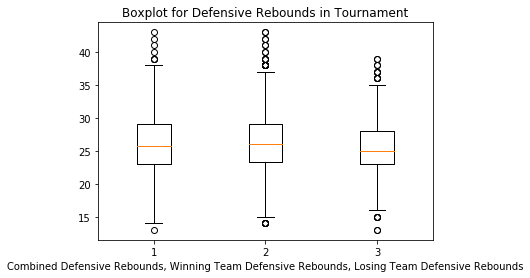

In [135]:
data = [df_tourney['DefensiveRebounds_Team'], df_winlose_tourney['DefensiveReboundsWin'], df_winlose_tourney['DefensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Defensive Rebounds in Tournament')
plt.xlabel('Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

#### Histogram

Text(0.5,1,u'Defensive Rebounds of Winning Team v. Losing Team')

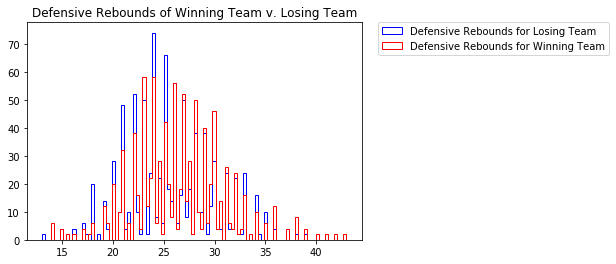

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Defensive Rebounds for Winning Team', 'Defensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['DefensiveReboundsWin'], df_winlose_tourney['DefensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Defensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [137]:
t, p = ttest_ind(df_winlose_tourney['DefensiveReboundsWin'], df_winlose_tourney['DefensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 3.73  p = 0.0002


#### Correlation Between (DefensiveRebounds_Team - DefensiveRebounds_Opponent) and Outcome

In [138]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['DefensiveReboundsDifference'] = df_tourney['DefensiveRebounds_Team'] - df_tourney['DefensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.12


### Analysis

The mean defensive rebounds for the regular season is 23.8 whereas the mean defensive rebounds in the tournament is 26.0, so the defensive rebounding is better for tournament teams, which makes sense.

For the regular season, the difference between the mean defensive rebounding of winning teams (24.1) v. losing teams (23.5) is about 0.6, and is statistically significant.  The correlation between the defensive rebounding of the teams and the outcome of the game (win/lose) is 0.19, which indicates a weak linear relationship.

For the tournament, the difference between the mean defensive rebounding of winning teams (26.4) v. losing teams (25.6) is about 0.8, and is statistically significant.  The correlation between the defensive rebounding of the teams and the outcome of the game (win/lose) is 0.12, which is a weak linear relationship.

This feature may provide some benefit to predicting the outcome of tournament games, especially the early games, which are more similar to regular season games.

## Conclusion

As seen from the analysis, tournament games are played by higher caliber teams, so the game statistics are higher for those teams, and the statistical spreads between the teams are narrower.  Games earlier in the tournament have a greater proportion of teams that are statistically unbalanced, and it is these games that can take advantage of features highlighted in this analysis.

Of the features considered, all features except three point shooting and free throw shooting (for tournament games) show a statistically significant difference between winning and losing teams.  Note that only two point shooting percent and defensive rebounding have a weak correlation with the outcome of the game.  Three point shooting percent, free throw shooting percent, and offensive rebounding have no correlation with the game outcome.

Therefore the model might consider the following features:
* The average two point shooting percentage of teams per season.
* The average defensive rebounds of teams per season.

and should not consider the following features:
* The average three point shooting percentage of teams per season.
* The average free throw shooting percentage of teams per season.
* The average offensive rebounds of teams per season.